# Mortgage PD scorecard

## Import libraries

In [164]:
%reset

In [165]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from optbinning import OptimalBinning, BinningProcess, Scorecard
from scipy.stats import spearmanr
from itertools import combinations
import numpy as np

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

## Step 1: Data Preparation

### Step 1.1: Data Loading

In [166]:
# Load the dataset
file_path = "data/mortgage_sample.csv"  # replace with the actual path or URL
df_raw = pd.read_csv(file_path)

In [167]:
df_raw.head()

,id,time,orig_time,first_time,mat_time,balance_time,LTV_time,interest_rate_time,hpi_time,gdp_time,...,investor_orig_time,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time,default_time,payoff_time,status_time,sample
0,1,25,-7,25,113,41303.420,24.498,9.200,226.290,2.899,...,0,45000.000,715,69.400,9.200,87.030,0.000,0.000,0.000,public
1,1,26,-7,25,113,41061.950,24.484,9.200,225.100,2.151,...,0,45000.000,715,69.400,9.200,87.030,0.000,0.000,0.000,public
2,1,27,-7,25,113,40804.420,24.627,9.200,222.390,2.362,...,0,45000.000,715,69.400,9.200,87.030,0.000,0.000,0.000,public
3,1,28,-7,25,113,40483.890,24.736,9.200,219.670,1.229,...,0,45000.000,715,69.400,9.200,87.030,0.000,0.000,0.000,public
4,1,29,-7,25,113,40367.060,24.925,9.200,217.370,1.693,...,0,45000.000,715,69.400,9.200,87.030,0.000,0.000,0.000,public


In [168]:
# Display basic information about the dataset
print("\nDataset Information:")
df_raw.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 622489 entries, 0 to 622488
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       622489 non-null  int64  
 1   time                     622489 non-null  int64  
 2   orig_time                622489 non-null  int64  
 3   first_time               622489 non-null  int64  
 4   mat_time                 622489 non-null  int64  
 5   balance_time             622489 non-null  float64
 6   LTV_time                 622219 non-null  float64
 7   interest_rate_time       622489 non-null  float64
 8   hpi_time                 622489 non-null  float64
 9   gdp_time                 622489 non-null  float64
 10  uer_time                 622489 non-null  float64
 11  REtype_CO_orig_time      622489 non-null  int64  
 12  REtype_PU_orig_time      622489 non-null  int64  
 13  REtype_SF_orig_time      622489 non-n

In [169]:
# Filter out private observations
df_public = df_raw[df_raw['sample'] == 'public']
df_public = df_public.drop(['sample'], axis=1)

#### Filter out ids which end with status_code==0. It means that the loan is still active and we don't know if it will default or not. We can't use this data for training.

In [170]:
filtered_ids = df_public.groupby('id')['status_time'].sum()[lambda x: x > 0].index
df_dev = df_public[df_public['id'].isin(filtered_ids)]

### Step 1.2: Data Exploration

In [171]:
# Display summary statistics
print("\nSummary Statistics:")
df_dev.describe()


Summary Statistics:


,id,time,orig_time,first_time,mat_time,balance_time,LTV_time,interest_rate_time,hpi_time,gdp_time,...,REtype_SF_orig_time,investor_orig_time,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time,default_time,payoff_time,status_time
count,342027.000,342027.000,342027.000,342027.000,342027.000,342027.000,341971.000,342027.000,342027.000,342027.000,...,342027.000,342027.000,342027.000,342027.000,342027.000,342027.000,342027.000,342027.000,342027.000,342027.000
mean,24568.109,31.138,20.060,23.445,136.701,259012.463,81.217,7.054,189.585,1.410,...,0.613,0.127,267099.857,672.250,79.143,5.583,196.080,0.040,0.070,0.180
std,13627.324,9.393,7.298,6.015,18.789,221656.838,23.539,1.877,29.075,2.030,...,0.487,0.333,227525.052,71.950,9.915,3.107,34.496,0.196,0.255,0.536
min,1.000,1.000,-40.000,1.000,23.000,0.000,0.000,0.000,107.830,-4.147,...,0.000,0.000,0.000,400.000,50.100,0.000,75.710,0.000,0.000,0.000
25%,13066.000,25.000,17.000,20.000,136.000,111755.715,66.091,5.875,161.000,1.104,...,0.000,0.000,116000.000,624.000,75.000,4.875,179.450,0.000,0.000,0.000
50%,24292.000,30.000,22.000,24.000,141.000,196363.270,79.945,6.875,188.370,1.851,...,1.000,0.000,200000.000,675.000,80.000,6.300,212.730,0.000,0.000,0.000
75%,36706.000,37.000,25.000,28.000,145.000,356341.240,97.400,8.000,217.370,2.899,...,1.000,0.000,368000.000,728.000,80.000,7.500,222.390,0.000,0.000,0.000
max,49984.000,60.000,60.000,60.000,229.000,8701859.240,248.432,37.500,226.290,5.132,...,1.000,1.000,8000000.000,840.000,178.600,18.000,226.290,1.000,1.000,2.000


#### New features

In [172]:
# balance orig time cannot be 0
df_dev = df_dev[df_dev['balance_orig_time'] > 0]

df_dev['time_until_mat'] = df_dev['mat_time'] - df_dev['time']
df_dev['time_since_orig'] = df_dev['time'] - df_dev['orig_time']
df_dev['balance_paid'] = df_dev['balance_orig_time'] - df_dev['balance_time']
df_dev['balance_paid_perc'] = df_dev['balance_paid'] / df_dev['balance_orig_time']

In [173]:
df_dev[['balance_orig_time', 'time_until_mat', 'time_since_orig','balance_paid', 'balance_paid_perc']].describe()

,balance_orig_time,time_until_mat,time_since_orig,balance_paid,balance_paid_perc
count,341971.000,341971.000,341971.000,341971.000,341971.000
mean,267143.596,105.565,11.076,8095.067,0.034
std,227518.004,19.285,9.080,38402.121,0.096
min,6246.000,1.000,0.000,-701859.240,-2.655
25%,116000.000,103.000,5.000,27.160,0.000
50%,200000.000,111.000,8.000,1251.710,0.008
75%,368000.000,115.000,15.000,5378.470,0.031
max,8000000.000,198.000,92.000,2251328.120,1.000


In [174]:
# Check for missing values
print("\nMissing Values:")
df_dev.isnull().sum()


Missing Values:


id                         0
time                       0
orig_time                  0
first_time                 0
mat_time                   0
balance_time               0
LTV_time                   0
interest_rate_time         0
hpi_time                   0
gdp_time                   0
uer_time                   0
REtype_CO_orig_time        0
REtype_PU_orig_time        0
REtype_SF_orig_time        0
investor_orig_time         0
balance_orig_time          0
FICO_orig_time             0
LTV_orig_time              0
Interest_Rate_orig_time    0
hpi_orig_time              0
default_time               0
payoff_time                0
status_time                0
time_until_mat             0
time_since_orig            0
balance_paid               0
balance_paid_perc          0
dtype: int64

In [175]:
# Count the number of rows with missing values
null_rows = df_dev.isnull().any(axis=0)
print("\nNumber of rows with missing values:", null_rows.sum())


Number of rows with missing values: 0


In [176]:
# First, select numerical variables only
num_vars = df_dev.select_dtypes(include=['float64', 'int64']).drop(columns=['id']).columns

print("\nDescriptive statistics:")
df_dev[num_vars].describe()


Descriptive statistics:


,time,orig_time,first_time,mat_time,balance_time,LTV_time,interest_rate_time,hpi_time,gdp_time,uer_time,...,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time,default_time,payoff_time,status_time,time_until_mat,time_since_orig,balance_paid,balance_paid_perc
count,341971.000,341971.000,341971.000,341971.000,341971.000,341971.000,341971.000,341971.000,341971.000,341971.000,...,341971.000,341971.000,341971.000,341971.000,341971.000,341971.000,341971.000,341971.000,341971.000,341971.000
mean,31.138,20.062,23.445,136.703,259048.529,81.217,7.054,189.582,1.410,6.084,...,79.143,5.583,196.092,0.040,0.070,0.180,105.565,11.076,8095.067,0.034
std,9.394,7.297,6.015,18.788,221657.035,23.539,1.876,29.075,2.030,1.876,...,9.914,3.106,34.486,0.196,0.255,0.536,19.285,9.080,38402.121,0.096
min,1.000,-40.000,1.000,23.000,0.000,0.000,0.000,107.830,-4.147,3.800,...,50.100,0.000,75.710,0.000,0.000,0.000,1.000,0.000,-701859.240,-2.655
25%,25.000,17.000,20.000,136.000,111788.730,66.091,5.875,161.000,1.104,4.700,...,75.000,4.875,179.450,0.000,0.000,0.000,103.000,5.000,27.160,0.000
50%,30.000,22.000,24.000,141.000,196399.020,79.945,6.875,188.370,1.851,5.000,...,80.000,6.300,212.730,0.000,0.000,0.000,111.000,8.000,1251.710,0.008
75%,37.000,25.000,28.000,145.000,356381.550,97.400,8.000,217.370,2.899,7.800,...,80.000,7.500,222.390,0.000,0.000,0.000,115.000,15.000,5378.470,0.031
max,60.000,60.000,60.000,229.000,8701859.240,248.432,37.500,226.290,5.132,10.000,...,178.600,18.000,226.290,1.000,1.000,2.000,198.000,92.000,2251328.120,1.000


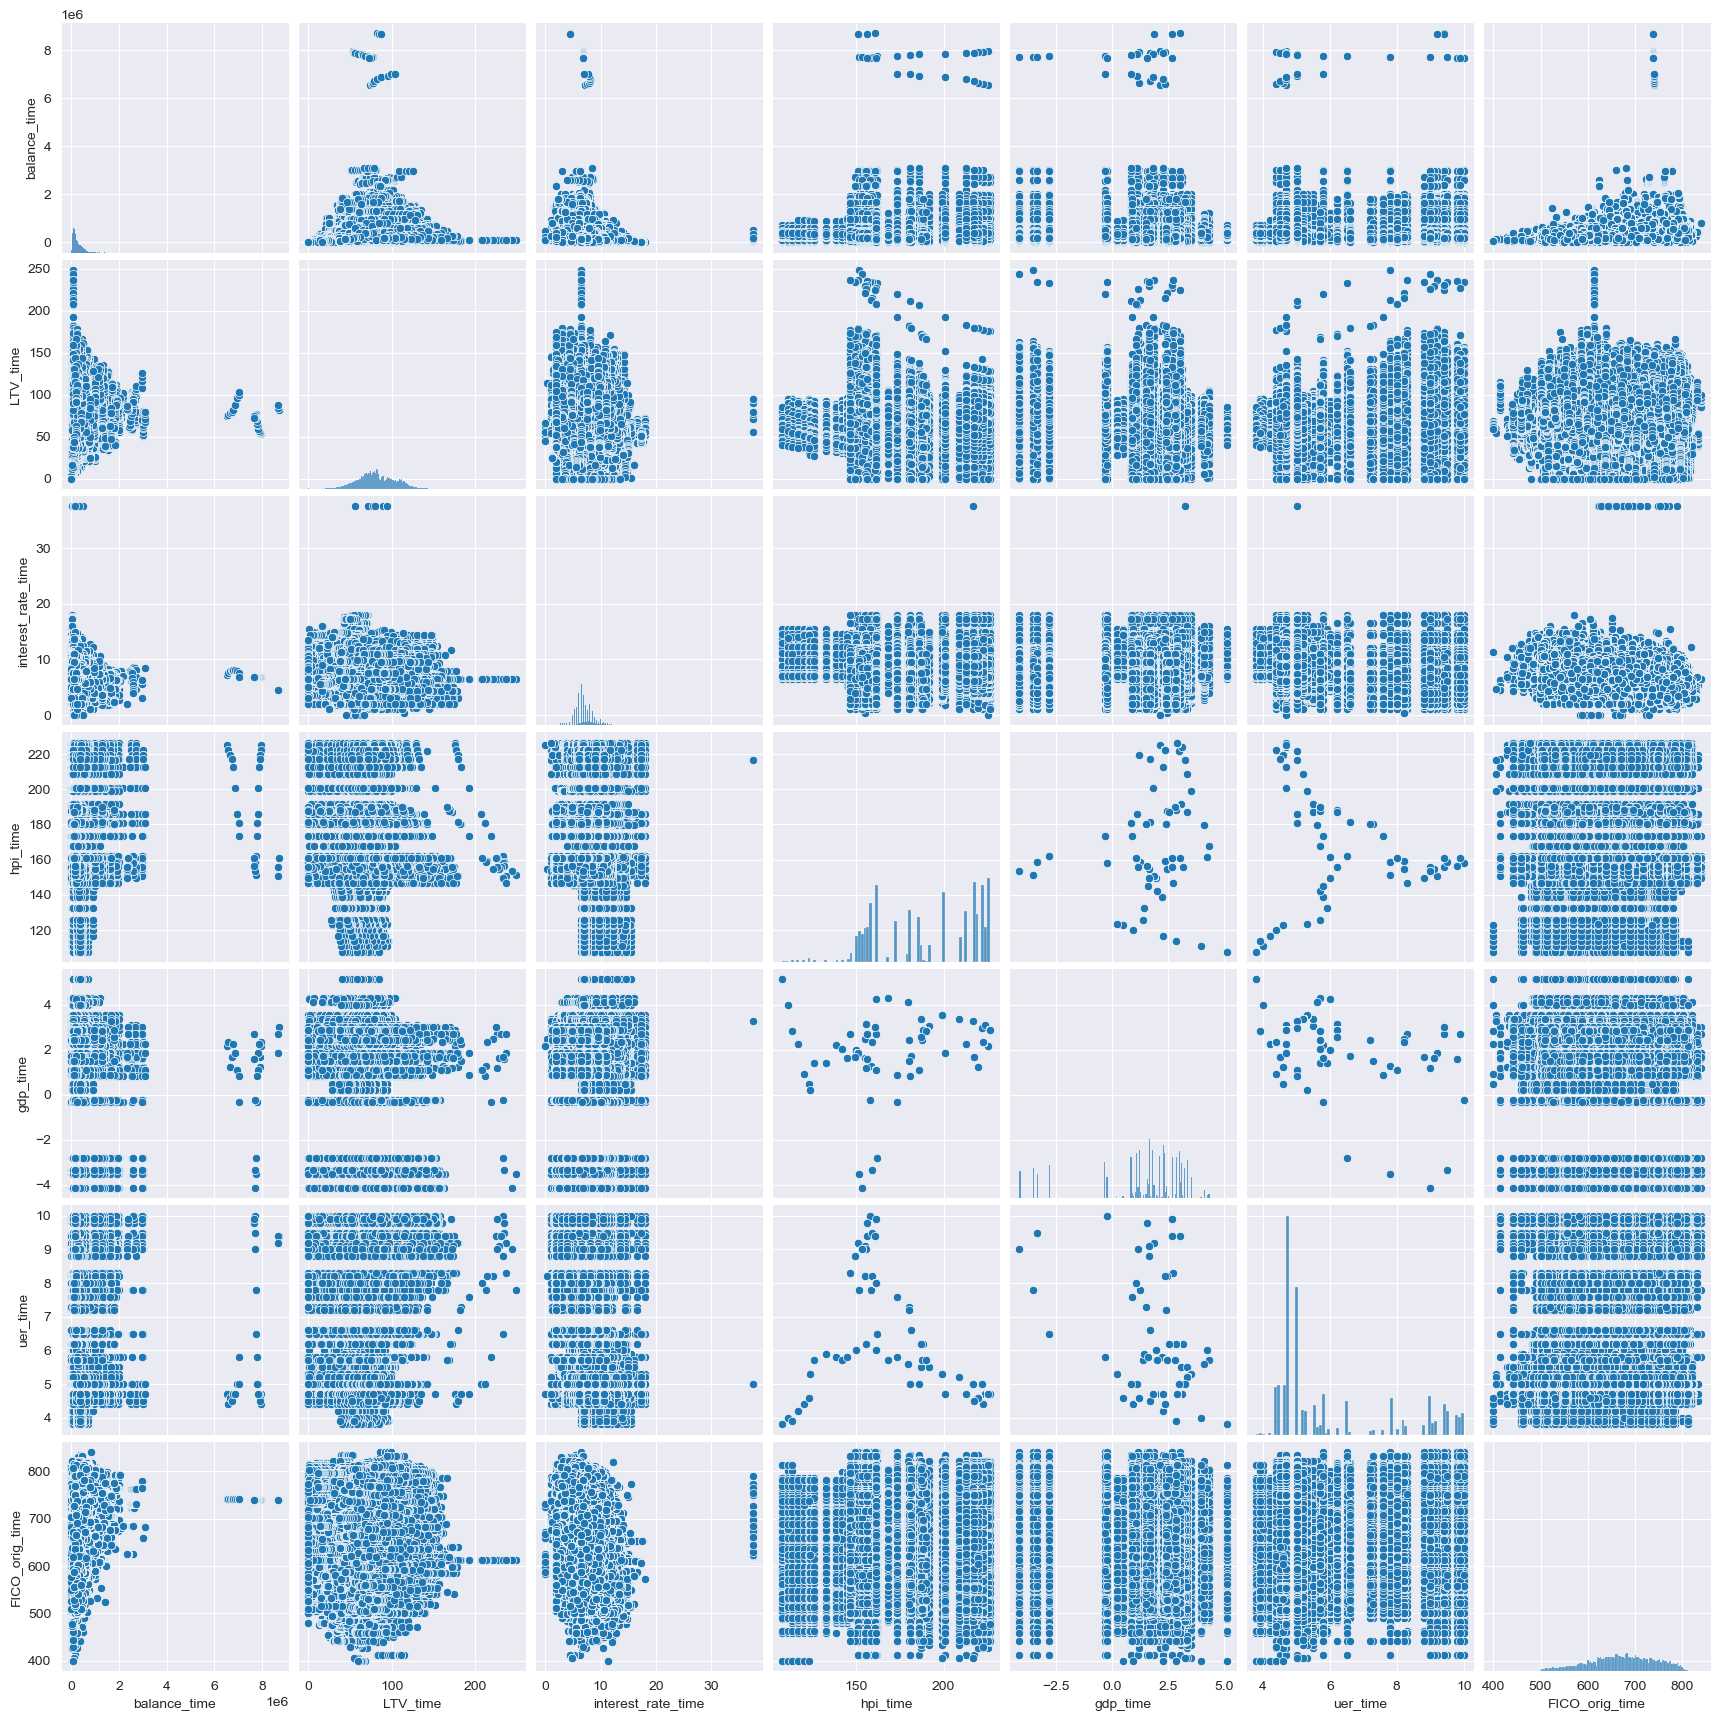

In [177]:
# Pairplot for numeric variables
sns.pairplot(df_dev[['balance_time', 'LTV_time', 'interest_rate_time', 'hpi_time', 'gdp_time', 'uer_time', 'FICO_orig_time']])
plt.show()


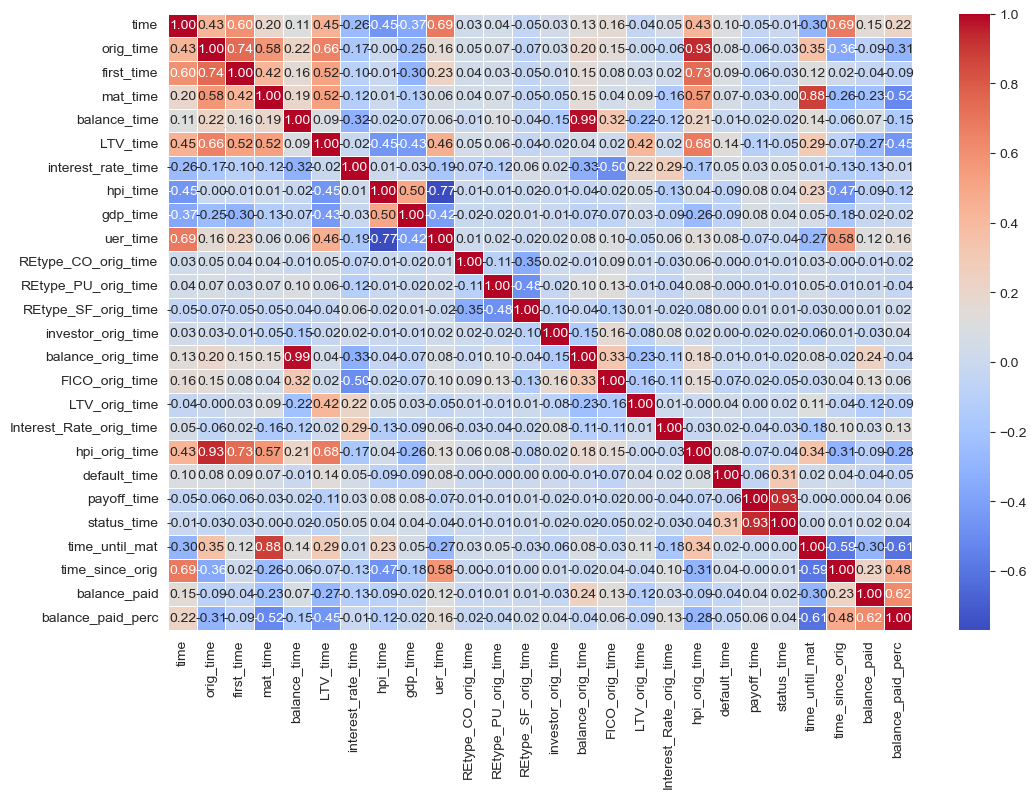

In [178]:
 # Correlation heatmap
correlation_matrix = df_dev.drop(columns=['id']).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()


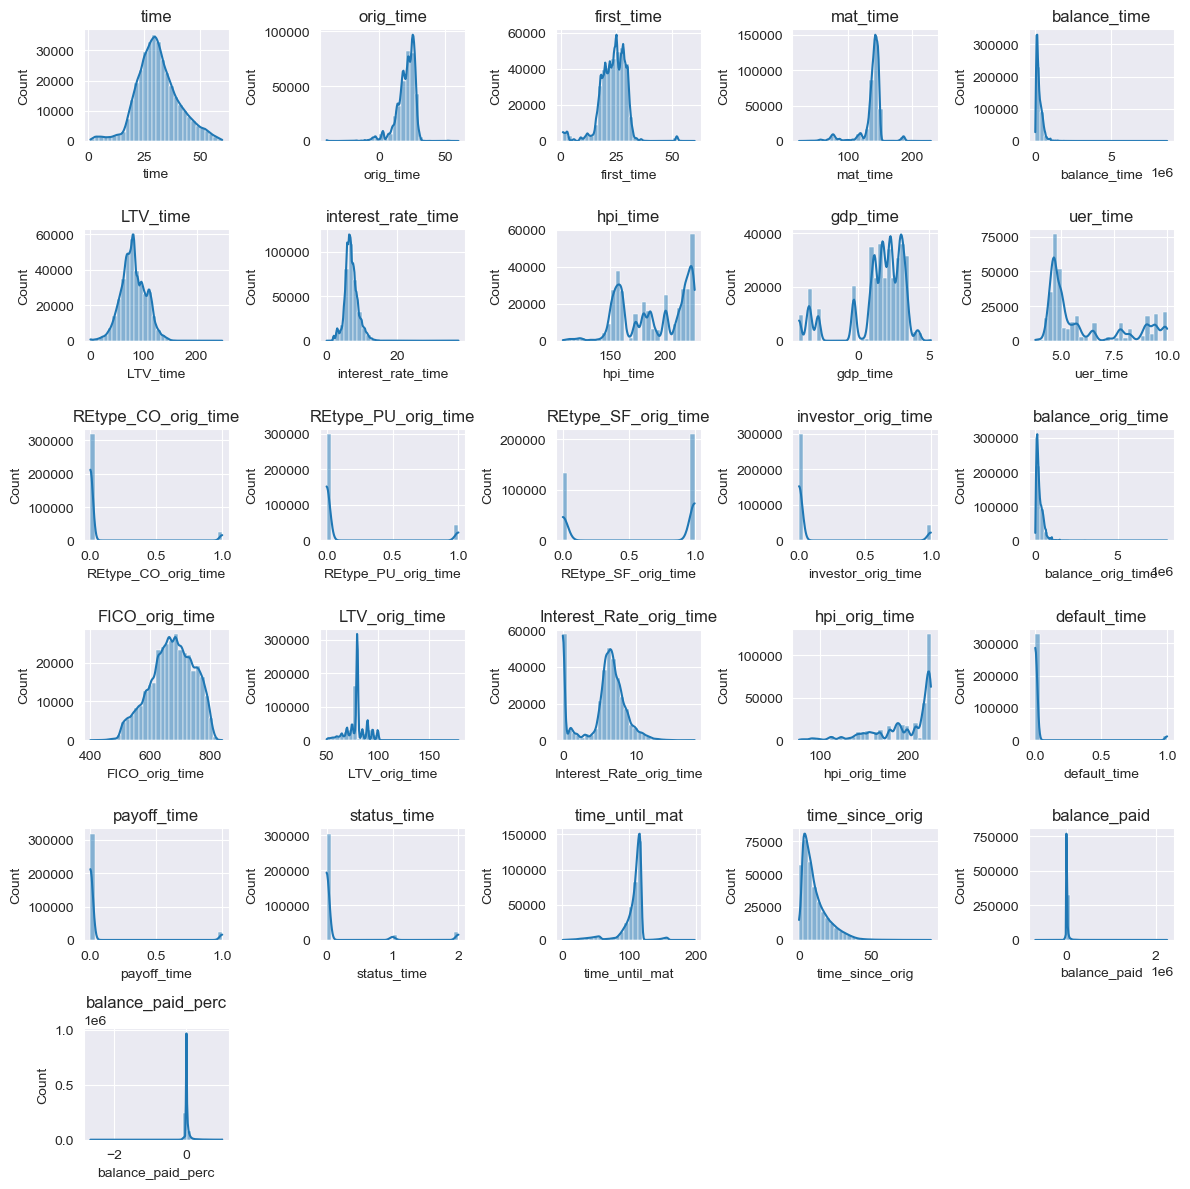

In [179]:
# Plot distributions
plt.figure(figsize=(12, 12))

for i, feature in enumerate(num_vars, 1):
    plt.subplot(6, 5, i)
    sns.histplot(df_dev[feature], bins=30, kde=True)
    plt.title(f'{feature}')
    plt.xlabel(feature)

plt.tight_layout()  # Add this line to prevent subplot overlap
plt.show()

In [180]:
# Group by home type and calculate the mean FICO score within each home type
home_type_fico_mean = df_dev.groupby(['REtype_SF_orig_time'])['FICO_orig_time'].mean()
print(home_type_fico_mean)

REtype_SF_orig_time
0   684.078
1   664.807
Name: FICO_orig_time, dtype: float64


### Step 1.3: Target construction

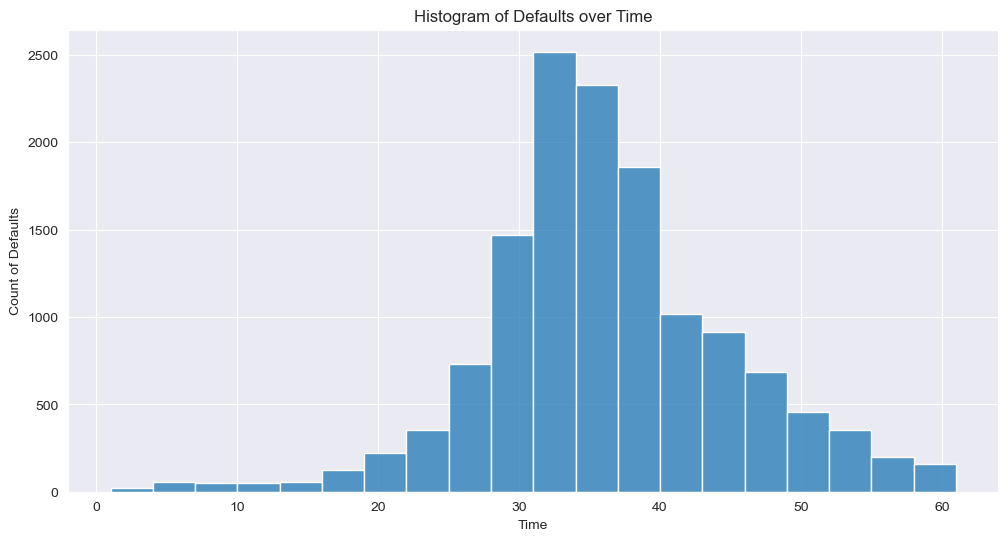

In [181]:
plt.figure(figsize=(12, 6))
sns.histplot(df_dev[df_dev['default_time'] == 1]['time'], binwidth=3, kde=False)
plt.title('Histogram of Defaults over Time')
plt.xlabel('Time')
plt.ylabel('Count of Defaults')
plt.show()

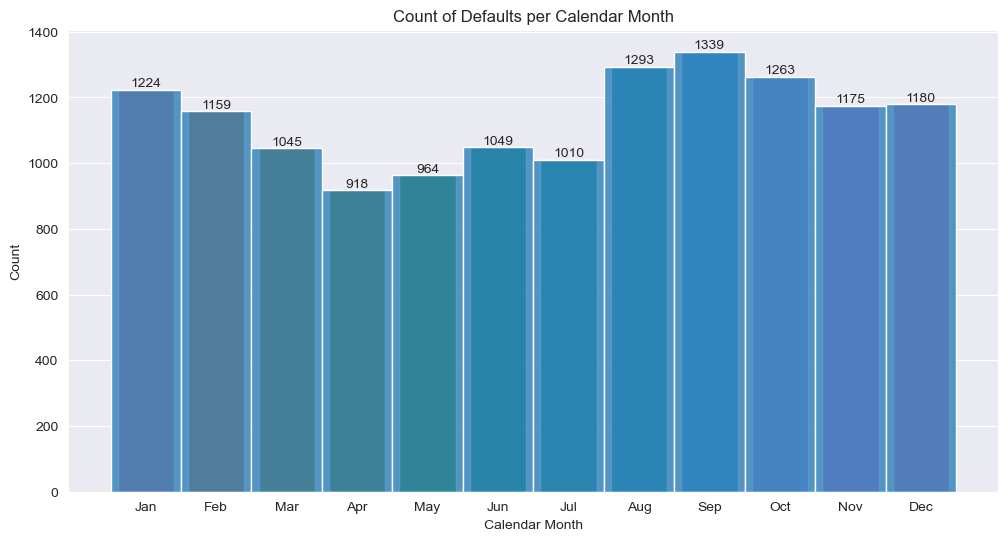

In [182]:
df_dev['calendar_month'] = df_dev['time'] % 12  # Extract the month from the 'time' column

# Filter data where 'default_time' is 1
default_df = df_dev[df_dev['default_time'] == 1]
count_per_month = default_df['calendar_month'].value_counts().sort_index()

# Plot histogram
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=count_per_month.index, y=count_per_month.values)
sns.histplot(default_df['calendar_month'], bins=range(13), kde=False, discrete=True)
plt.title('Count of Defaults per Calendar Month')
plt.xlabel('Calendar Month')
plt.ylabel('Count')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

for i, value in enumerate(count_per_month.values):
    ax.text(i, value + 0.1, str(value), ha='center', va='bottom')
    
plt.show()

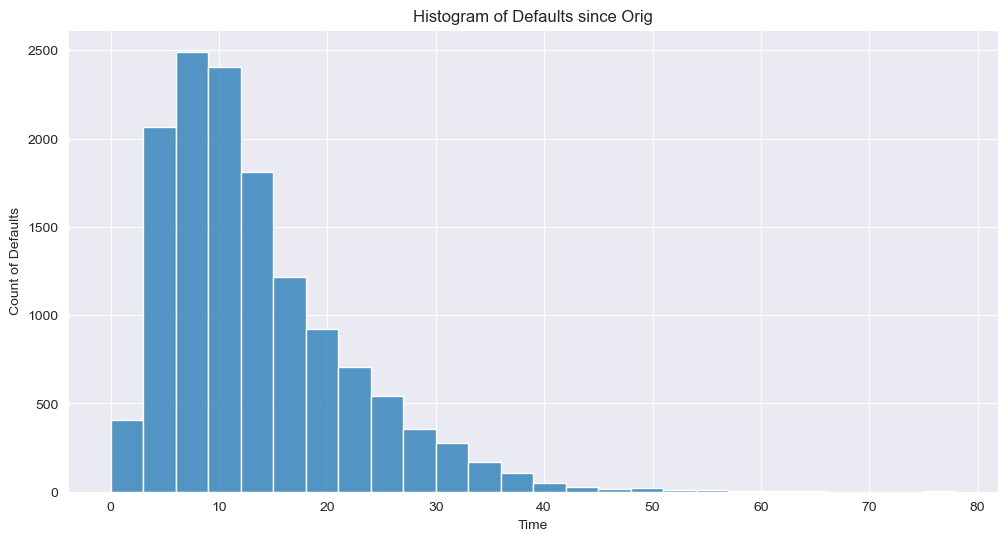

In [183]:
plt.figure(figsize=(12, 6))
sns.histplot(df_dev[df_dev['default_time'] == 1]['time_since_orig'], binwidth=3, kde=False)
plt.title('Histogram of Defaults since Orig')
plt.xlabel('Time')
plt.ylabel('Count of Defaults')
plt.show()

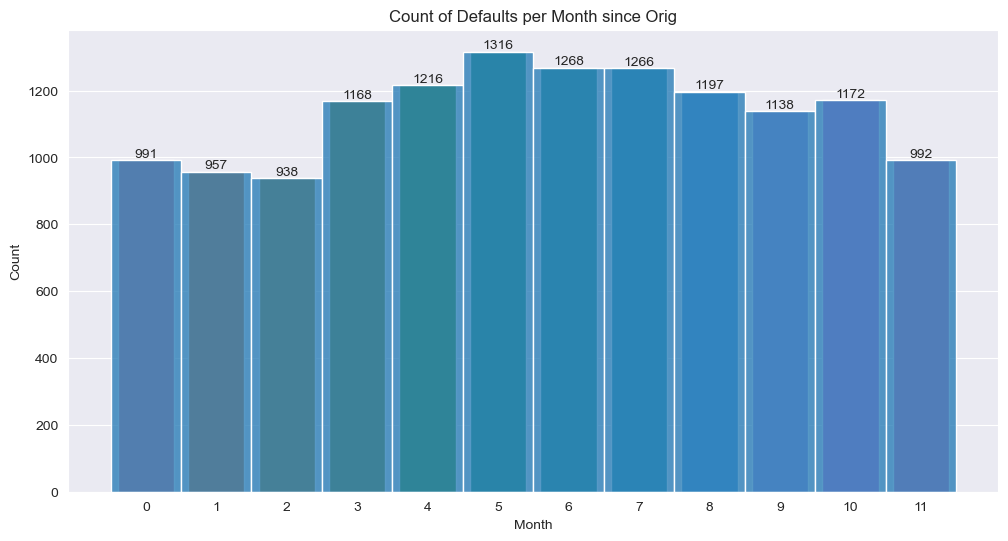

In [184]:
df_dev['month_since_orig'] = df_dev['time_since_orig'] % 12  # Extract the month from the 'time' column

# Filter data where 'default_time' is 1
default_df = df_dev[df_dev['default_time'] == 1]
count_per_month = default_df['month_since_orig'].value_counts().sort_index()

# Plot histogram
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=count_per_month.index, y=count_per_month.values)
sns.histplot(default_df['month_since_orig'], bins=range(13), kde=False, discrete=True)
plt.title('Count of Defaults per Month since Orig')
plt.xlabel('Month')
plt.ylabel('Count')

for i, value in enumerate(count_per_month.values):
    ax.text(i, value + 0.1, str(value), ha='center', va='bottom')

plt.show()

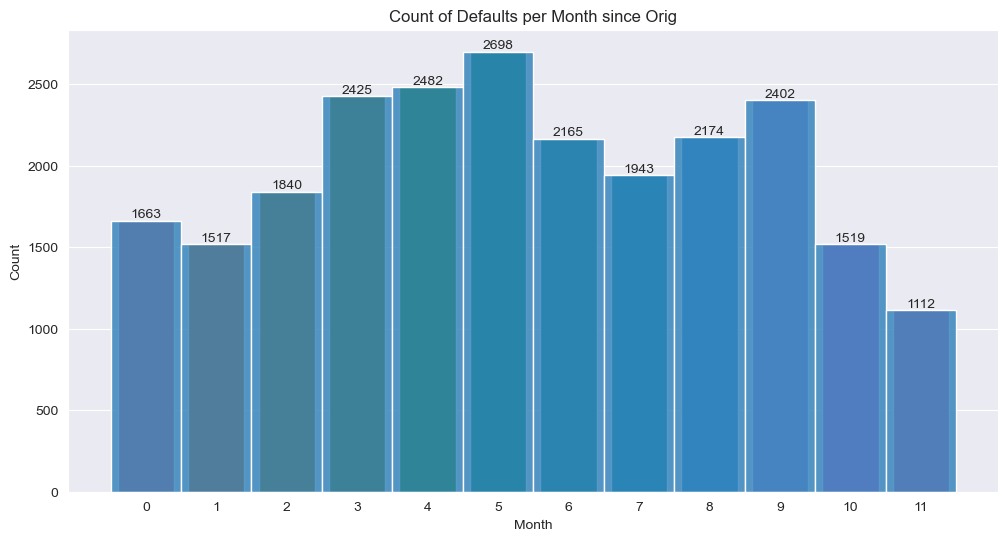

In [185]:
# Filter data where 'default_time' is 1
payoff_df = df_dev[df_dev['payoff_time'] == 1]
count_per_month = payoff_df['month_since_orig'].value_counts().sort_index()

# Plot histogram
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=count_per_month.index, y=count_per_month.values)
sns.histplot(payoff_df['month_since_orig'], bins=range(13), kde=False, discrete=True)
plt.title('Count of Defaults per Month since Orig')
plt.xlabel('Month')
plt.ylabel('Count')

for i, value in enumerate(count_per_month.values):
    ax.text(i, value + 0.1, str(value), ha='center', va='bottom')

plt.show()

Let's choose as a cohort the time since origination. We will check if the client defaulted in the every next 12 months since origination.

#### Building target variable

##### Check initial distribution of defaulted clients

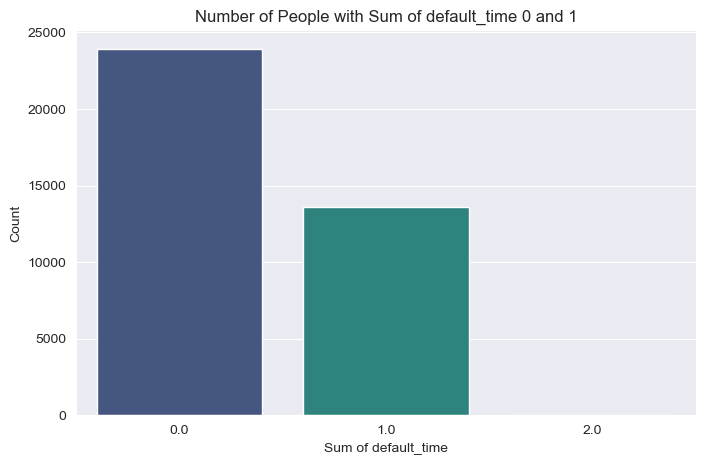

In [186]:
# Group by 'id' and calculate the sum of 'default_time'
df_default_sum = df_dev.groupby('id')['default_time'].sum()

# Plot bar chart
plt.figure(figsize=(8, 5))
sns.countplot(x=df_default_sum, palette='viridis')
plt.title('Number of People with Sum of default_time 0 and 1')
plt.xlabel('Sum of default_time')
plt.ylabel('Count')
plt.show()

The distribution of defaulted clients is imbalanced.

Also, we can see that there are clients who defaulted more than once. Let's check how many of them are there, and drop them from the dataset.

In [187]:
# Filter out clients who defaulted more than once
print("Number of clients who defaulted more than once:", len(df_default_sum[df_default_sum > 1]))

Number of clients who defaulted more than once: 4


In [188]:
# Drop clients who defaulted more than once
df_dev = df_dev[~df_dev['id'].isin(df_default_sum[df_default_sum > 1].index)]

##### Target logic

If the client defaults (default_time == 1) within 12-months-window since origination, then we will mark the cohort as 1, otherwise 0.

In [189]:
df_dev['target'] = 0

In [190]:
def mark_defaults(df):
    # Create a copy of the DataFrame
    df_copy = df.copy()

    # Group by id and take the last observation per id
    last_observation = df.groupby('id').last()

    # Mark rows where the last observation has 'default_time' equal to 1
    defaulted_ids = last_observation[last_observation['default_time'] == 1].index

    # Iterate over defaulted_ids and update 'target' column accordingly
    for defaulted_id in defaulted_ids:
        # Filter rows for the current defaulted_id
        df_id = df_copy[df_copy['id'] == defaulted_id]

        # Find the value of 'month_since_orig' for the last observation
        last_month_since_orig = df_id['month_since_orig'].tail(1).values[0]

        # Set the 'target' column to 1 in the last n+1 rows
        df_copy.loc[df_id.index[-(last_month_since_orig+1):], 'target'] = 1

    return df_copy


In [191]:
df_dev = mark_defaults(df_dev)

### Step 1.4: Setting Cohort

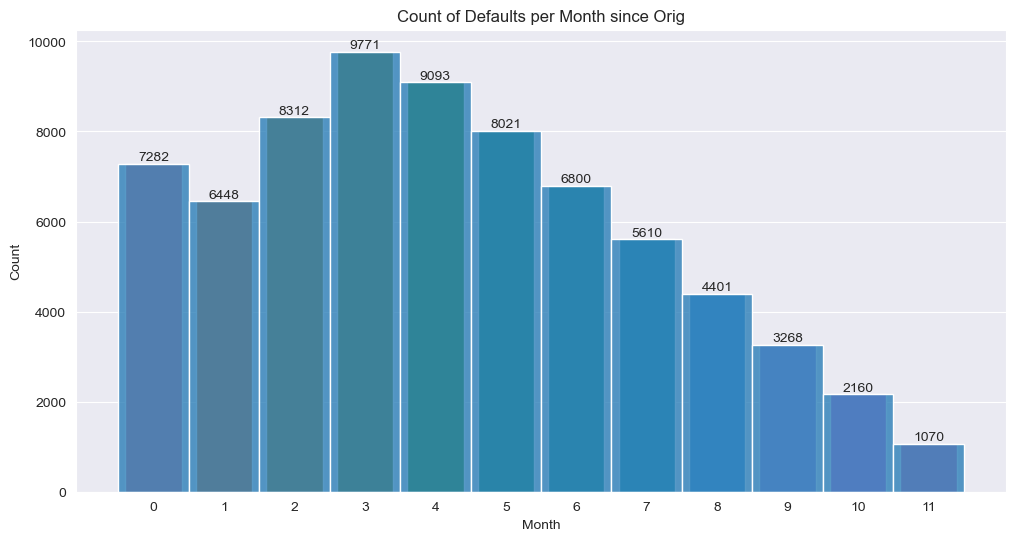

In [192]:
# Filter data where 'target' is 1
default_df = df_dev[df_dev['target'] == 1]
count_per_month = default_df['month_since_orig'].value_counts().sort_index()

# Plot histogram
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=count_per_month.index, y=count_per_month.values)
sns.histplot(default_df['month_since_orig'], bins=range(13), kde=False, discrete=True)
plt.title('Count of Defaults per Month since Orig')
plt.xlabel('Month')
plt.ylabel('Count')

for i, value in enumerate(count_per_month.values):
    ax.text(i, value + 0.1, str(value), ha='center', va='bottom')

plt.show()

Let's choose a flexible cohort – every 4th month since origination

In [193]:
df_dev = df_dev[df_dev['month_since_orig'] == 3]

# Drop columns that we don't need anymore
df_dev.drop(columns=['id', 'time', 'orig_time', 'first_time', 'mat_time', 'default_time', 'payoff_time', 'status_time', 'calendar_month', 'month_since_orig'], inplace=True)

Distribution of target:
target
0    28944
1     9771
Name: count, dtype: int64


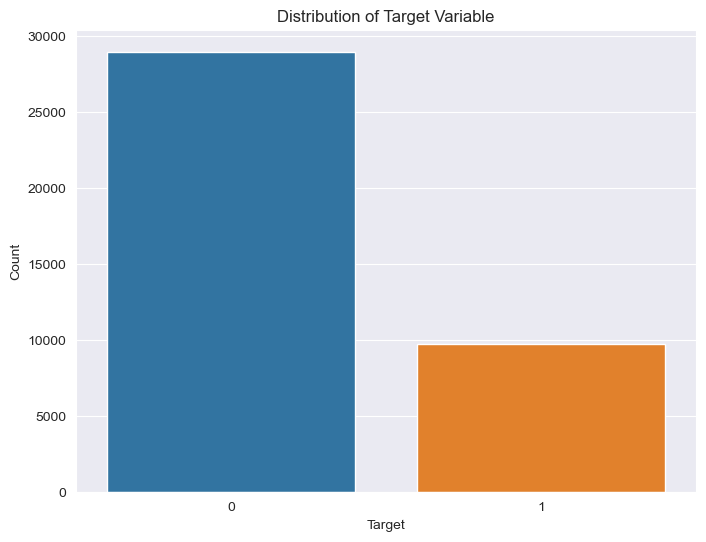

In [194]:
print("Distribution of target:", df_dev['target'].value_counts(), sep='\n')

plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=df_dev)
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

The target distribution is imbalanced. Most of the clients didn't default.

### Step 1.5: Outlier Treatment

In [195]:
pd.options.display.float_format = '{:.3f}'.format
df_dev.drop(columns=['target']).describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])

,balance_time,LTV_time,interest_rate_time,hpi_time,gdp_time,uer_time,REtype_CO_orig_time,REtype_PU_orig_time,REtype_SF_orig_time,investor_orig_time,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time,time_until_mat,time_since_orig,balance_paid,balance_paid_perc
count,38715.000,38715.000,38715.000,38715.000,38715.000,38715.000,38715.000,38715.000,38715.000,38715.000,38715.000,38715.000,38715.000,38715.000,38715.000,38715.000,38715.000,38715.000,38715.000
mean,259763.402,79.554,7.132,196.629,1.929,5.774,0.068,0.128,0.618,0.127,265803.688,668.731,79.403,5.506,198.751,109.193,8.205,6040.286,0.025
std,215607.784,19.539,1.755,28.429,1.682,1.768,0.253,0.334,0.486,0.333,220458.006,71.175,9.795,3.192,32.467,18.386,8.902,33654.373,0.084
min,0.000,0.000,1.000,107.830,-4.147,3.800,0.000,0.000,0.000,0.000,9575.000,400.000,50.100,0.000,75.910,1.000,3.000,-245697.840,-0.763
5%,53759.580,47.637,4.625,150.910,-2.806,4.400,0.000,0.000,0.000,0.000,56900.000,542.000,60.200,0.000,132.760,65.000,3.000,-2742.820,-0.010
25%,116728.375,69.873,6.000,167.910,1.586,4.700,0.000,0.000,0.000,0.000,120000.000,621.000,75.000,4.375,186.910,105.000,3.000,0.050,0.000
50%,200000.000,78.866,6.990,208.860,2.274,5.000,0.000,0.000,1.000,0.000,203520.000,671.000,80.000,6.375,216.770,117.000,3.000,537.680,0.004
75%,352849.840,88.482,8.104,219.670,3.029,5.800,0.000,0.000,1.000,0.000,360000.000,723.000,81.000,7.500,222.390,117.000,15.000,2538.250,0.014
95%,622053.014,113.085,10.250,226.290,3.556,9.800,1.000,1.000,1.000,1.000,636000.000,780.000,95.000,9.750,226.290,118.000,27.000,28860.886,0.125
max,7899963.800,233.575,18.000,226.290,5.132,10.000,1.000,1.000,1.000,1.000,8000000.000,840.000,178.600,18.000,226.290,198.000,87.000,2000000.000,1.000


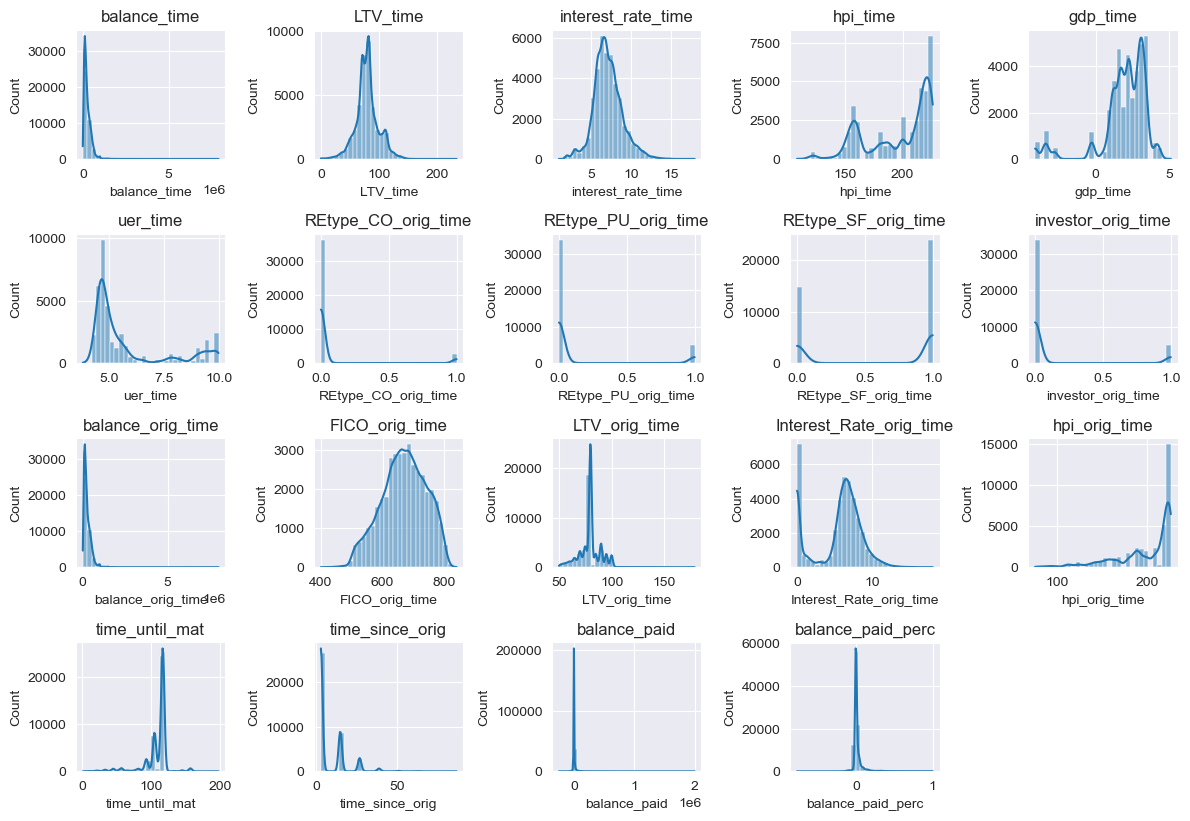

In [196]:
num_vars = df_dev.select_dtypes(include=['float64', 'int64']).drop(columns=['target']).columns

plt.figure(figsize=(12, 12))
for i, feature in enumerate(num_vars, 1):
    plt.subplot(6, 5, i)
    sns.histplot(df_dev[feature], bins=30, kde=True)
    plt.title(f'{feature}')
    plt.xlabel(feature)

plt.tight_layout()
plt.show()

Convert outliers into 5th and 95th quantiles values

In [197]:
# According to the distribution plots, the following columns have outliers:
treat_columns = [
    "balance_time", "LTV_time", "interest_rate_time",
    "hpi_time", "gdp_time", "balance_orig_time",
    "FICO_orig_time", "LTV_orig_time", "Interest_Rate_orig_time",
    "hpi_orig_time", "time_until_mat" ,"time_since_orig",
    "balance_paid", "balance_paid_perc"
]

def outlier_treatment(df):
    df_copy = df[treat_columns].copy()

    # Iterate over the columns in df
    for col in df_copy.columns:
        # Calculate 5th and 95th percentiles
        q_05, q_95 = df_copy[col].quantile([0.05, 0.95])

        # Replace the outliers
        df_copy[col] = df_copy[col].clip(q_05, q_95, axis=0)

    return df_copy

In [198]:
df_dev[treat_columns] = outlier_treatment(df_dev)

In [199]:
# (DONE) TODO: Binning
# (DONE) TODO: Correlation Analysis
# (DONE) TODO: Feature Selection
# TODO: Model training
# TODO: Scorecard building
# TODO: Scorecard validation

## Step 2: Binning process

The first step is to set breakpoints for individual bins

In [200]:
predictors = df_dev.drop('target', axis =1).columns.to_list()


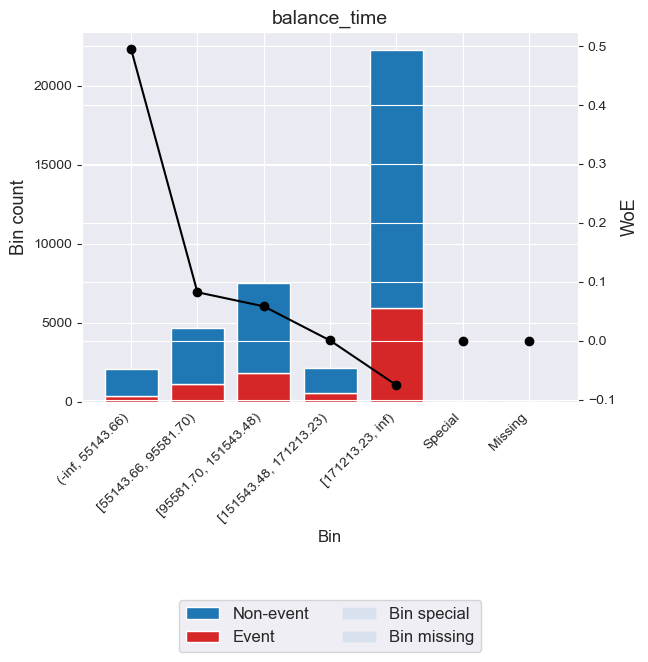

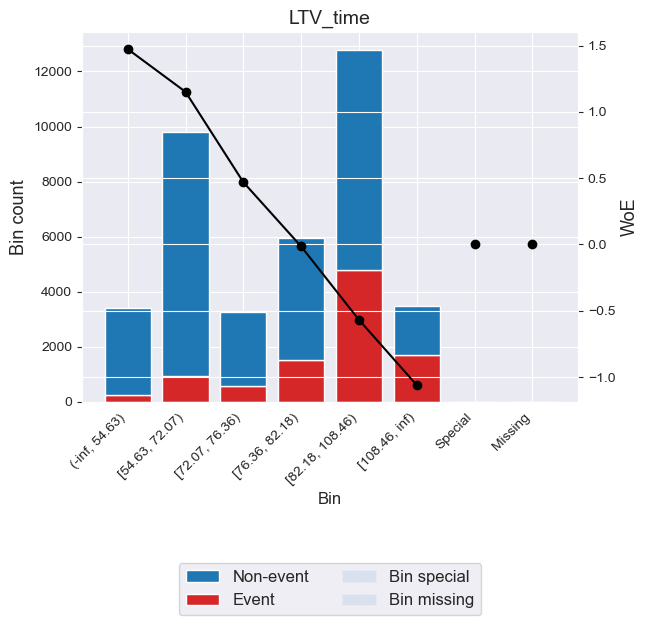

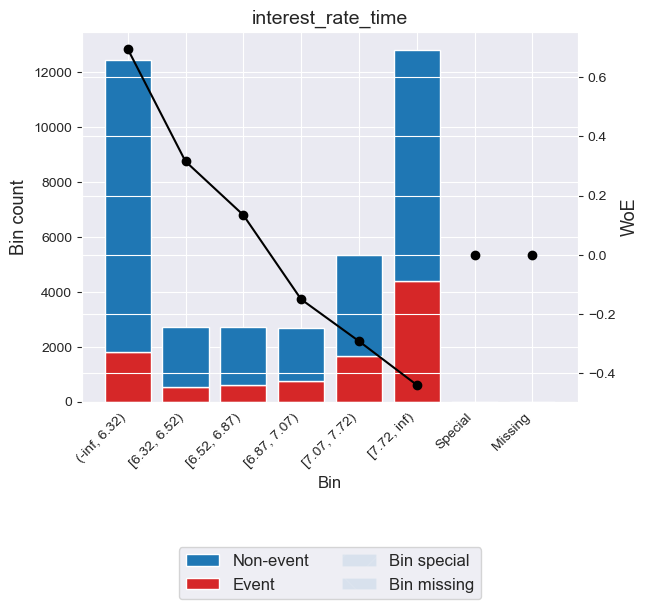

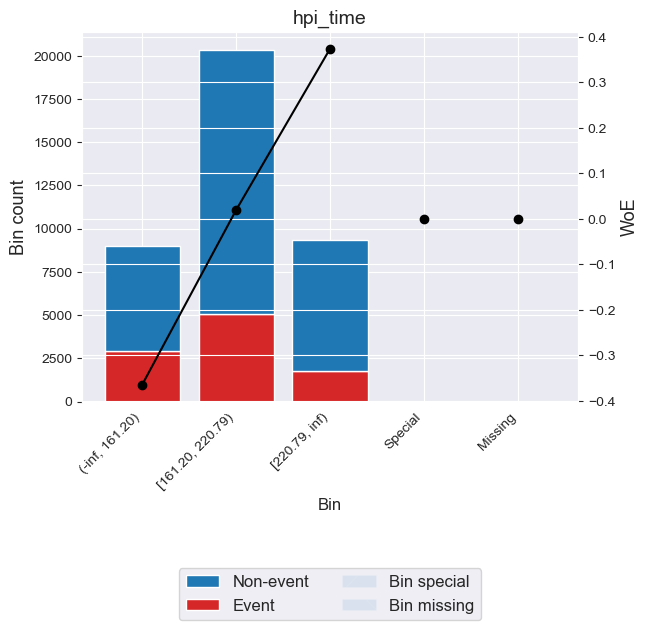

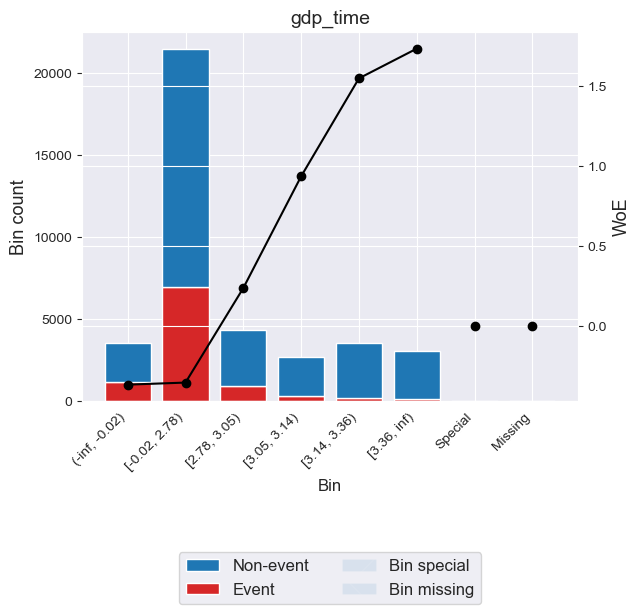

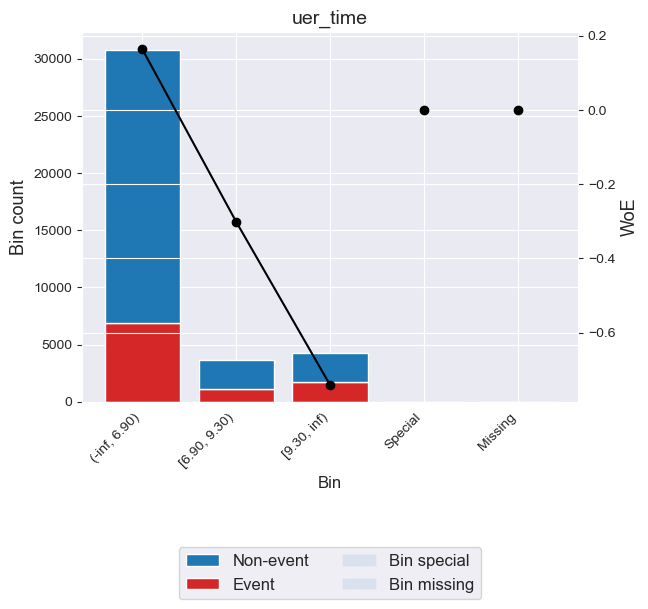

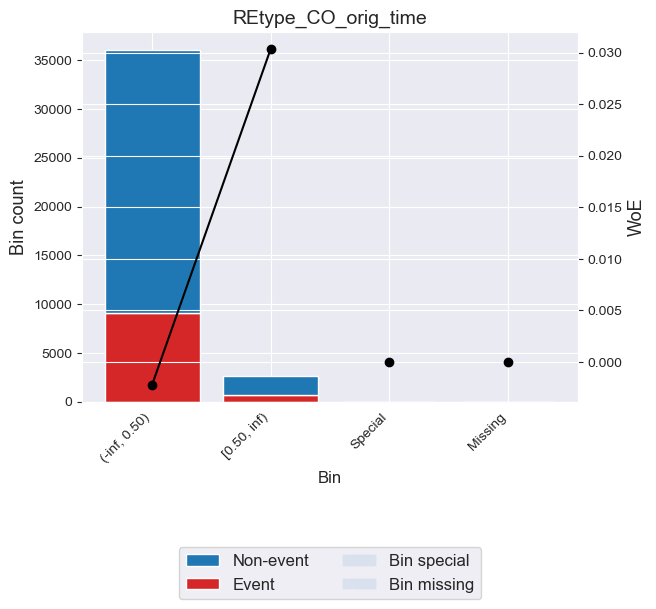

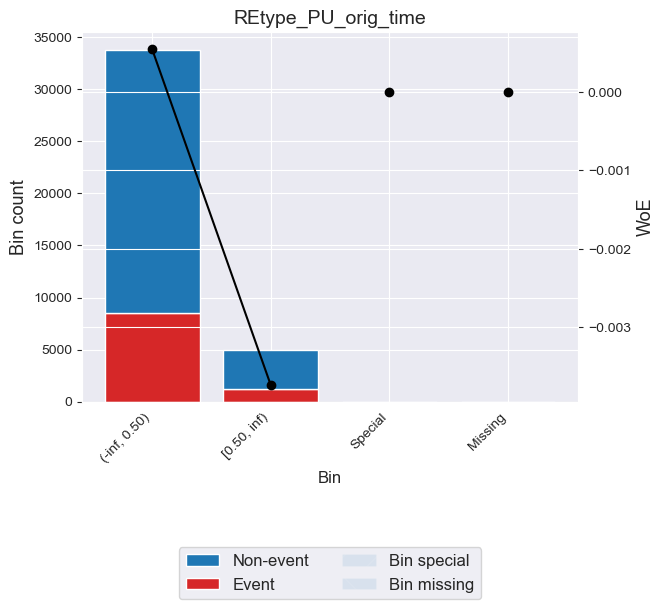

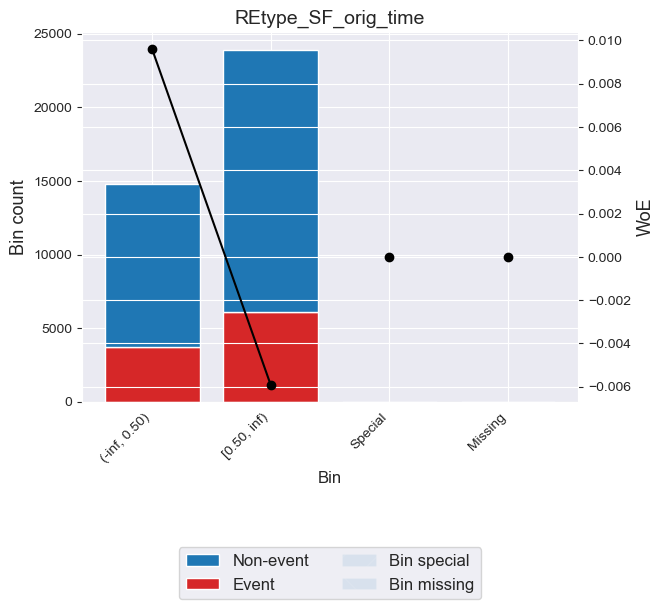

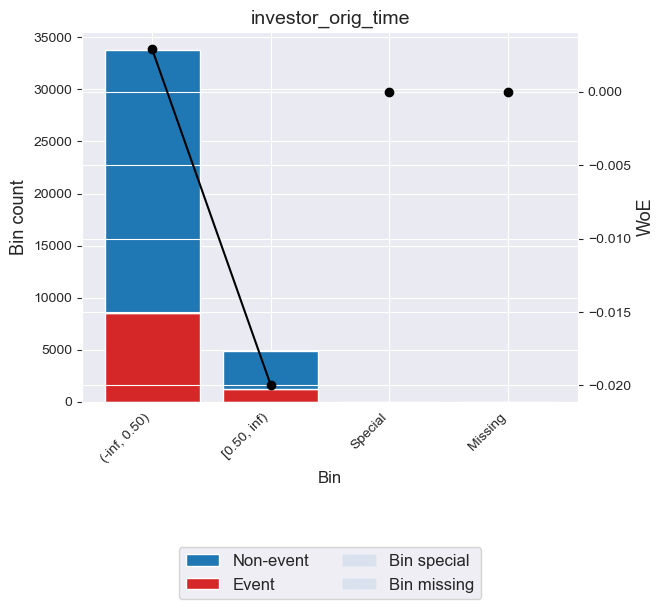

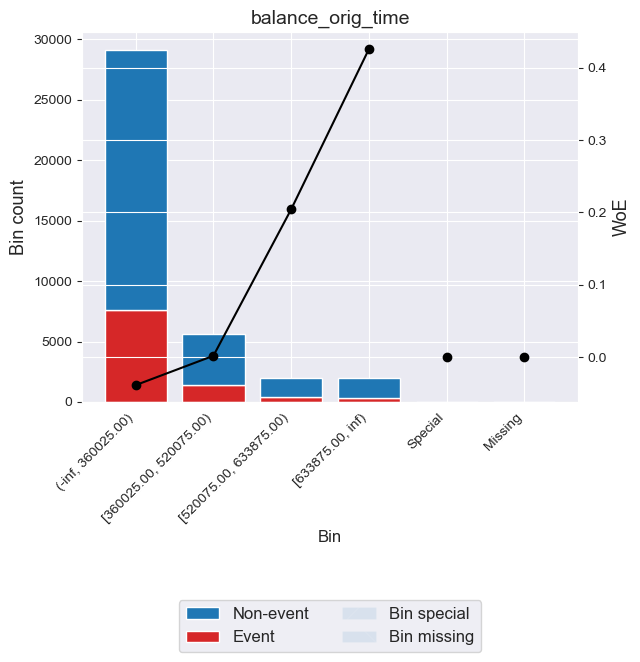

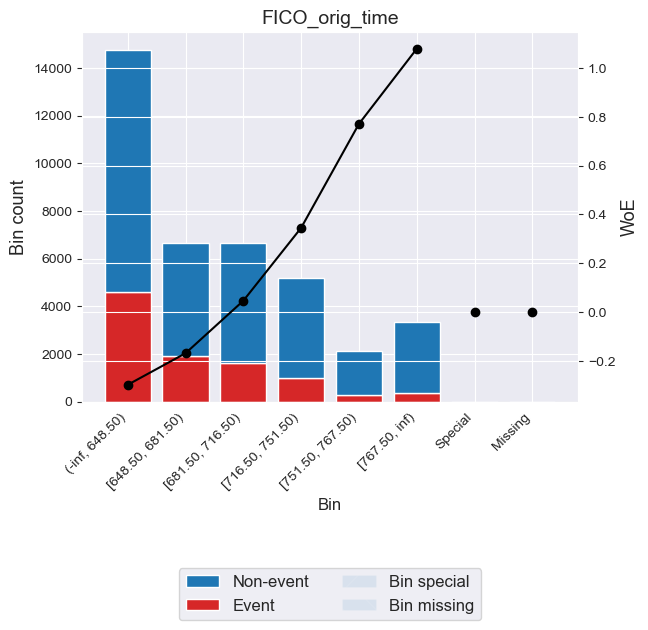

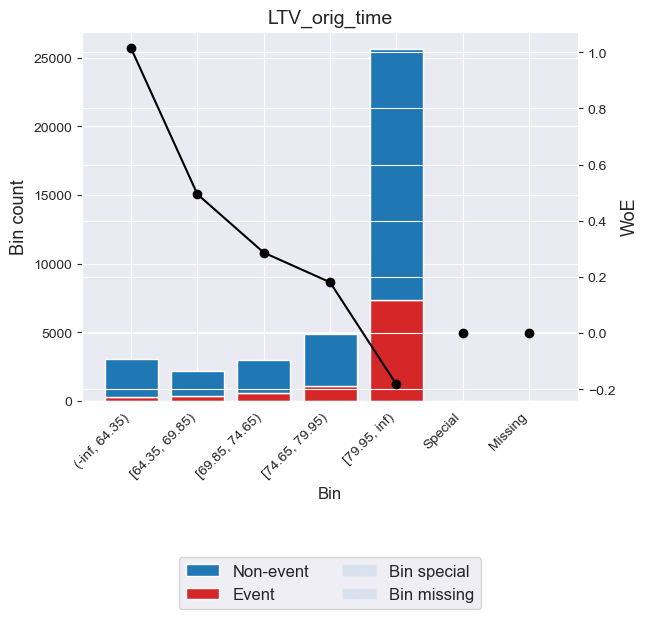

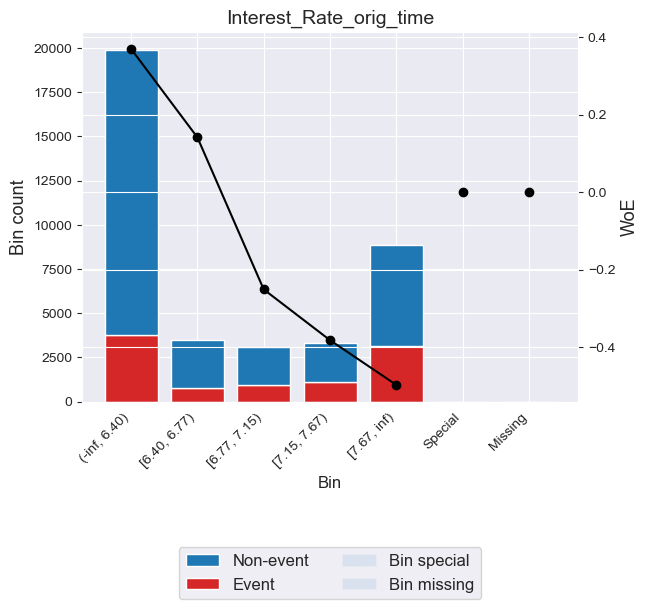

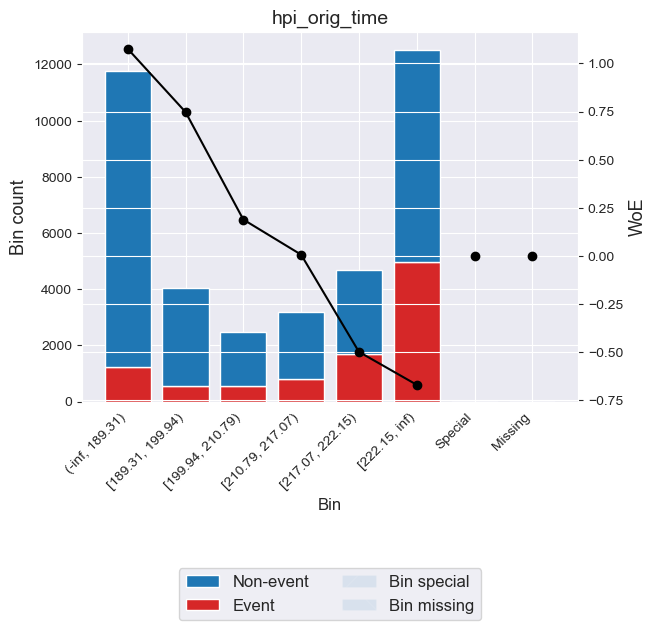

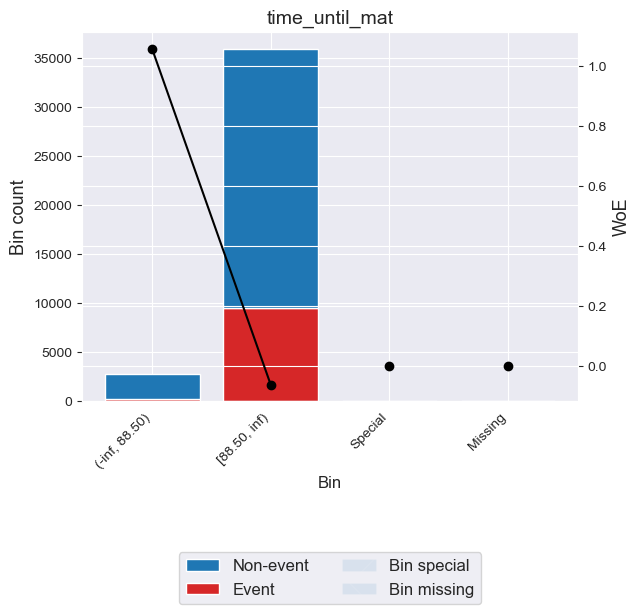

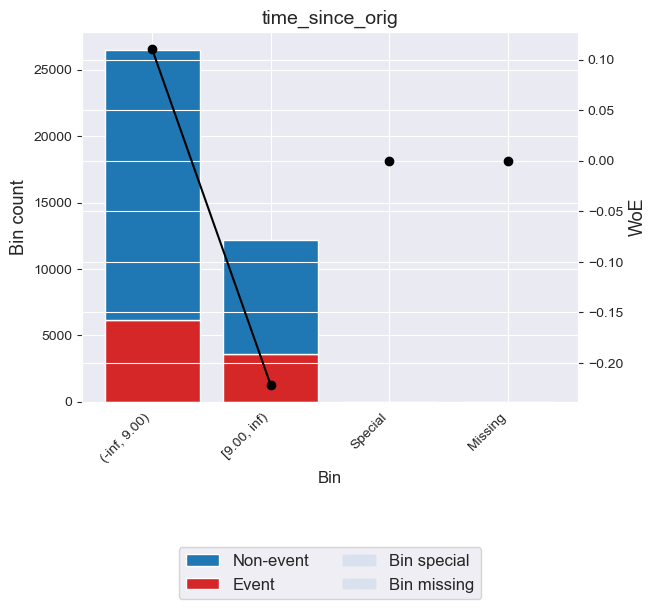

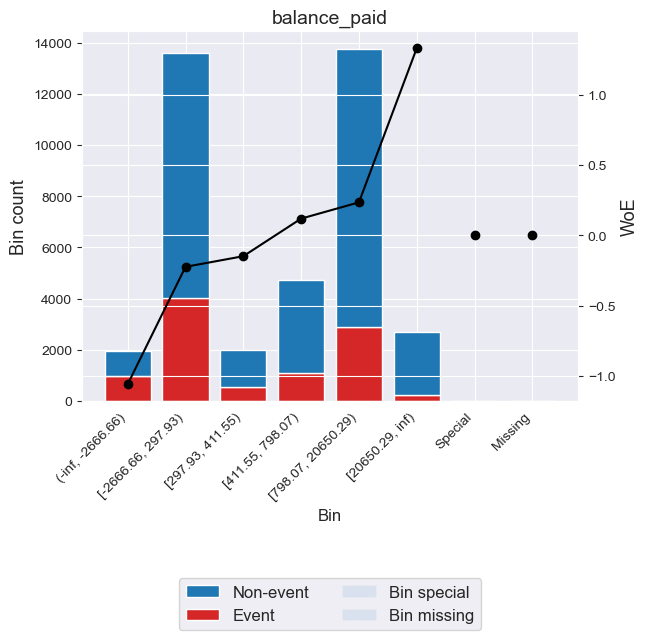

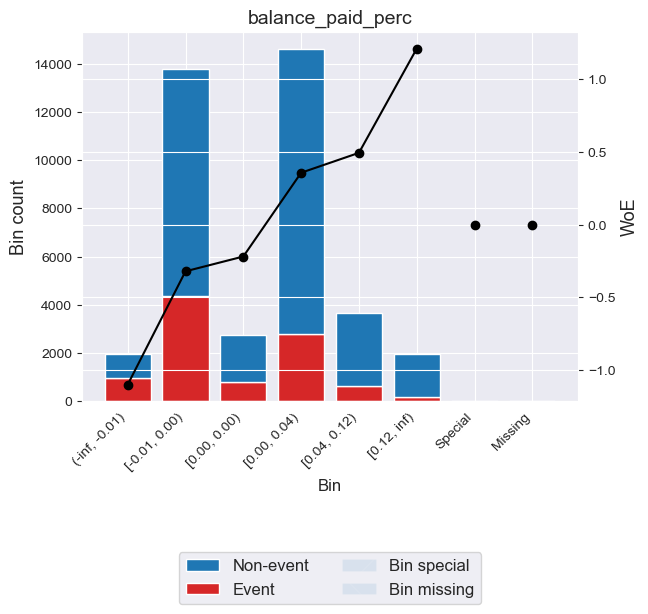

In [201]:
for predictor in predictors:
    X = df_dev[predictor]
    y = df_dev['target']
    
    optb = OptimalBinning(name=predictor, monotonic_trend = "auto_asc_desc", max_n_bins=6)
    optb.fit(X, y)
    optb.binning_table.build()
    optb.binning_table.plot(metric="woe",show_bin_labels=True)

## Step 3: Univariate analysis

Total results for all predictors. The predictors selected for the model must have a Gini coefficient greater than 0.2 (20%). Therefore, let's add this criterion to the function.

In [202]:
binning_process = BinningProcess(
    variable_names = predictors, 
    min_bin_size=0.05,
    max_n_bins=6
)

X = df_dev.drop('target', axis =1)
y = df_dev['target']

X_transformed = binning_process.fit_transform(X, y, metric='woe')
binning_process.summary().sort_values(by='gini', ascending=False)

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
1,LTV_time,numerical,OPTIMAL,True,6,0.624,0.074,0.413,0.668
14,hpi_orig_time,numerical,OPTIMAL,True,6,0.516,0.062,0.373,0.828
4,gdp_time,numerical,OPTIMAL,True,6,0.451,0.052,0.304,0.799
5,uer_time,numerical,OPTIMAL,True,6,0.406,0.047,0.291,0.819
2,interest_rate_time,numerical,OPTIMAL,True,6,0.281,0.034,0.267,0.816
13,Interest_Rate_orig_time,numerical,OPTIMAL,True,6,0.270,0.033,0.267,0.830
18,balance_paid_perc,numerical,OPTIMAL,True,6,0.233,0.028,0.247,0.644
17,balance_paid,numerical,OPTIMAL,True,6,0.192,0.023,0.207,0.496
11,FICO_orig_time,numerical,OPTIMAL,True,6,0.156,0.019,0.193,0.528
3,hpi_time,numerical,OPTIMAL,True,5,0.156,0.018,0.161,0.471


In [203]:
# binning_process_selected = BinningProcess(
#     variable_names = list(X_transformed.columns),
#     min_bin_size=0.05,
#     max_n_bins=6
# )
# 
# X = df_dev[list(X_transformed.columns)]
# y = df_dev['target']
# 
# binning_process_selected.fit_transform(X, y, metric='woe')
# binning_process_selected.summary().sort_values(by='gini', ascending=False)

In [204]:
df_dev[list(X_transformed.columns)]

,balance_time,LTV_time,interest_rate_time,hpi_time,gdp_time,uer_time,REtype_CO_orig_time,REtype_PU_orig_time,REtype_SF_orig_time,investor_orig_time,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time,time_until_mat,time_since_orig,balance_paid,balance_paid_perc
7,53759.580,47.637,9.200,186.120,1.104,5.000,0,0,1,0,56900.000,715,69.400,9.200,132.760,81,27,9122.970,0.125
19,53759.580,47.637,9.200,150.910,1.876,9.200,0,0,1,0,56900.000,715,69.400,9.200,132.760,69,27,14414.570,0.125
78,205088.160,85.459,9.625,173.350,-0.314,5.800,0,0,1,0,212000.000,670,80.000,6.580,191.420,105,15,6911.840,0.033
90,197340.100,91.605,6.580,155.610,1.176,9.000,0,0,1,0,212000.000,670,80.000,6.580,191.420,93,27,14659.900,0.069
111,131081.220,84.826,8.000,180.520,0.837,5.000,0,0,1,0,128000.000,542,80.000,8.000,186.910,105,15,-2742.820,-0.010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622215,241955.160,94.358,7.000,161.130,1.081,8.000,0,1,0,1,242000.000,691,67.200,7.000,226.290,93,27,44.840,0.000
622234,78004.350,101.200,7.500,161.130,1.081,8.000,0,0,1,1,86600.000,672,80.000,7.500,226.290,93,27,8595.650,0.099
622246,180673.240,103.307,7.500,161.130,1.081,8.000,0,0,1,0,196000.000,708,79.800,7.500,226.290,93,27,15326.760,0.078
622342,198562.010,57.587,6.500,173.170,0.893,7.600,0,0,0,0,232000.000,665,74.800,6.500,155.770,81,27,28860.886,0.125


## Step 4: Correlation analysis

Perform a correlation analysis using the Spearman coefficient between the predictors and find pairs between them that have a high coefficient

In [205]:
X = df_dev.drop('target', axis =1)
correlation_results = []
variable_combinations = combinations(X.columns, 2)

for var1, var2 in variable_combinations:
    coef, p_value = spearmanr(X[var1], X[var2])
    if abs(coef) > 0.4:
        significance = 'Significant' if p_value < 0.05 else 'Not Significant'
        correlation_results.append({
            'Variable Pair': f'{var1} - {var2}',
            'Spearman Coefficient': coef,
            'p-value': p_value,
            'Significance': significance
        })

correlation_results_df = pd.DataFrame(correlation_results)

correlation_results_df[['Variable Pair', 'Spearman Coefficient']].sort_values(by='Spearman Coefficient', ascending=False)

,Variable Pair,Spearman Coefficient
0,balance_time - balance_orig_time,0.992
17,balance_paid - balance_paid_perc,0.962
10,uer_time - time_since_orig,0.599
2,LTV_time - hpi_orig_time,0.547
1,LTV_time - LTV_orig_time,0.503
5,interest_rate_time - Interest_Rate_orig_time,0.467
16,time_since_orig - balance_paid_perc,0.460
7,hpi_time - time_until_mat,0.452
15,time_since_orig - balance_paid,0.442
3,interest_rate_time - balance_orig_time,-0.404


Based on the Gini coefficient, pairwise correlation coefficient and linearity, the following variables were selected for the model: 

In [206]:
selected_columns = ['LTV_time', 'hpi_orig_time', 'gdp_time', 'uer_time', 'Interest_Rate_orig_time', 'balance_paid_perc', 'FICO_orig_time']

X_transformed = X_transformed[selected_columns]

In [158]:
# X_transformed.columns = ['LTV_time_woe', 'hpi_orig_time_woe', 'gdp_time_woe', 'uer_time_woe', 'Interest_Rate_orig_time_woe', 'balance_paid_perc_woe', 'FICO_orig_time_woe']
# X_transformed.head()

,LTV_time_woe,hpi_orig_time_woe,gdp_time_woe,uer_time_woe,Interest_Rate_orig_time_woe,balance_paid_perc_woe,FICO_orig_time_woe
0,1.474,0.760,-0.272,0.634,-0.498,1.208,0.046
1,1.474,0.760,-0.272,-0.301,-0.498,1.208,0.046
2,-0.568,0.748,-0.272,0.332,0.141,0.356,-0.169
3,-0.568,0.748,-0.272,-0.301,0.141,0.493,-0.169
4,-0.568,1.189,-0.272,0.634,-0.498,-1.099,-0.298


## Step 5: Model training

### Using Logistic Regression

In [207]:
param_grid = {
    'class_weight': ['balanced', None], # as we have unbalanced dataset
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [100, 10, 1.0, 0.1, 0.01],
    'solver': ['newton-cg', 'lbfgs', 'liblinear']
}


# Split into train and temp (which will be split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(X_transformed, y, test_size=0.3, random_state=42, stratify=y)

# Split temp into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)



In [208]:
model = LogisticRegression() 
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='recall', error_score=0)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

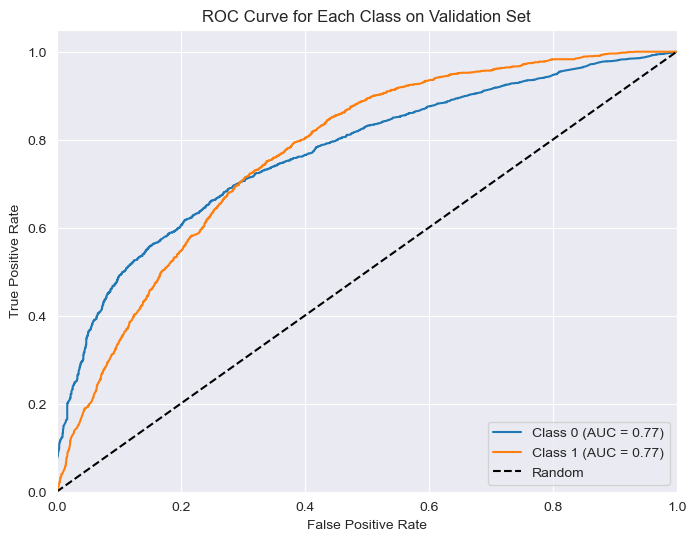

GINI 0: 0.54
GINI 1: 0.54


In [209]:
y_pred = best_model.predict_proba(X_val)

fpr0, tpr0, _ = roc_curve(y_val, y_pred[:, 0], pos_label=0)
fpr1, tpr1, _ = roc_curve(y_val, y_pred[:, 1], pos_label=1)

# Calculate AUC for each class
auc0 = auc(fpr0, tpr0)
auc1 = auc(fpr1, tpr1)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr0, tpr0, label=f'Class 0 (AUC = {auc0:.2f})')
plt.plot(fpr1, tpr1, label=f'Class 1 (AUC = {auc1:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class on Validation Set')
plt.legend(loc="lower right")
plt.show()

print(f'GINI 0: {2 * (auc0 - 0.5):.2f}')
print(f'GINI 1: {2 * (auc1 - 0.5):.2f}')

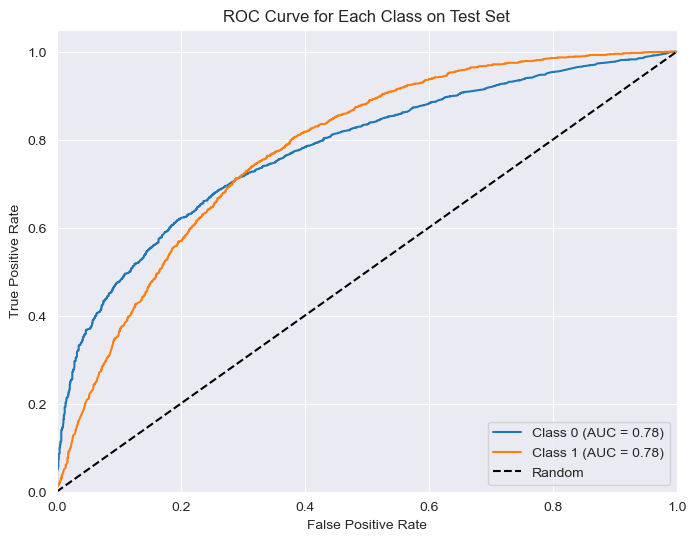

GINI 0: 0.55
GINI 1: 0.55


In [210]:
y_pred = best_model.predict_proba(X_test)

fpr0, tpr0, _ = roc_curve(y_test, y_pred[:, 0], pos_label=0)
fpr1, tpr1, _ = roc_curve(y_test, y_pred[:, 1], pos_label=1)

# Calculate AUC for each class
auc0 = auc(fpr0, tpr0)
auc1 = auc(fpr1, tpr1)



# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr0, tpr0, label=f'Class 0 (AUC = {auc0:.2f})')
plt.plot(fpr1, tpr1, label=f'Class 1 (AUC = {auc1:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class on Test Set')
plt.legend(loc="lower right")
plt.show()

print(f'GINI 0: {2 * (auc0 - 0.5):.2f}')
print(f'GINI 1: {2 * (auc1 - 0.5):.2f}')

## Step 6: Scorecard development

In [211]:
binning_process_selected = BinningProcess(
    variable_names = list(X_transformed.columns),
    min_bin_size=0.05,
    max_n_bins=6
)

X = df_dev[list(X_transformed.columns)]
y = df_dev['target']

binning_process_selected.fit_transform(X, y, metric='woe')
binning_process_selected.summary().sort_values(by='gini', ascending=False)

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
0,LTV_time,numerical,OPTIMAL,True,6,0.624,0.074,0.413,0.668
1,hpi_orig_time,numerical,OPTIMAL,True,6,0.516,0.062,0.373,0.828
2,gdp_time,numerical,OPTIMAL,True,6,0.451,0.052,0.304,0.799
3,uer_time,numerical,OPTIMAL,True,6,0.406,0.047,0.291,0.819
4,Interest_Rate_orig_time,numerical,OPTIMAL,True,6,0.270,0.033,0.267,0.830
5,balance_paid_perc,numerical,OPTIMAL,True,6,0.233,0.028,0.247,0.644
6,FICO_orig_time,numerical,OPTIMAL,True,6,0.156,0.019,0.193,0.528


In [ ]:
# Initialize the Scorecard with the binning process and logistic regression model
scorecard = Scorecard(
    binning_process=binning_process_selected, 
    estimator=best_model,
    scaling_method="pdo_odds",
    scaling_method_params={"odds": 1/51, "pdo": 50, "scorecard_points": 500},
    intercept_based=True,
    rounding=True
)

# Fit the Scorecard
scorecard.fit(X_train, y_train)

# Get the scorecard table (summary style)
scorecard_table = scorecard.table(style='detailed')

In [232]:
filtered_scorecard_table = scorecard_table[['Variable', 'Bin', 'Points', 'WoE', 'Event rate', 'Count (%)', 'Coefficient']]

filtered_scorecard_table = filtered_scorecard_table[filtered_scorecard_table['Bin'] != 'Special']
filtered_scorecard_table.columns = ['Variable', 'Group', 'Scorecard Points', 'WoE', 'DR', 'Percentage of population', 'Coefficient']

print(filtered_scorecard_table)

                  Variable           Group  Scorecard Points    WoE    DR  \
0                 LTV_time   (-inf, -0.81)             0.000 -1.065 0.495   
1                 LTV_time  [-0.81, -0.29)            22.000 -0.568 0.373   
2                 LTV_time   [-0.29, 0.23)            45.000 -0.022 0.257   
3                 LTV_time    [0.23, 0.81)            67.000  0.482 0.173   
4                 LTV_time    [0.81, 1.31)            96.000  1.156 0.096   
5                 LTV_time     [1.31, inf)           111.000  1.502 0.070   
7                 LTV_time         Missing            46.000  0.000 0.000   
0            hpi_orig_time   (-inf, -0.58)             0.000 -0.677 0.399   
1            hpi_orig_time  [-0.58, -0.21)             0.000 -0.498 0.357   
2            hpi_orig_time   [-0.21, 0.42)             1.000  0.092 0.236   
3            hpi_orig_time    [0.42, 0.75)             1.000  0.693 0.144   
4            hpi_orig_time    [0.75, 0.97)             2.000  0.810 0.131   